In [2]:
import numpy as np
import pandas as pd 
import re
from keras.preprocessing.text import Tokenizer 
import nltk
from nltk import download
download('stopwords')
from nltk.corpus import stopwords


import json
import gzip
import os
import sys
import argparse
#import panda as pd
import matplotlib.pyplot as plt
import re
# Library for boxplots
import seaborn as sns
from tqdm import tqdm

from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import warnings
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences

#from tensorflow.keras.layers import Attention
#from attention import AttentionLayer

#from keras_self_attention import SeqSelfAttention
pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")



[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Malo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
def readData(path,filename):
    json_obj_list=[]
    with open(os.path.join(path,filename),'r') as fin:
        for row in fin:
            json_obj_list.append(json.loads(row))
    return json_obj_list

In [ ]:
CURRENCIES = {
    "$": "USD", "zł": "PLN", "£": "GBP", "¥": "JPY", "฿": "THB", "₡": "CRC", "₦": "NGN","₩": "KRW",
    "₪": "ILS", "₫": "VND", "€": "EUR", "₱": "PHP", "₲": "PYG", "₴": "UAH", "₹": "INR",}
CURRENCY_REGEX = re.compile(
    "({})+".format("|".join(re.escape(c) for c in CURRENCIES.keys())))

EMAIL_REGEX = re.compile(
    r"(?:^|(?<=[^\w@.)]))([\w+-](\.(?!\.))?)*?[\w+-]@(?:\w-?)*?\w+(\.([a-z]{2,})){1,3}(?:$|(?=\b))",
    flags=re.IGNORECASE | re.UNICODE,)

# A list of contractions from http://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python
contractions =          {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have", "i've": "i have"}
def clean_text(text, remove_stopwords = True):
    
    text = text.lower()
    if True:
        text = text.split()
        new_text = []
        for word in text:
            if word in contractions:
                print("contract")
                new_text.append(contractions[word])
            else:
                new_text.append(word)
        text = " ".join(new_text)
        
    text = re.sub(r'https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
    text = EMAIL_REGEX.sub(' ',text)
    text = CURRENCY_REGEX.sub(' ',text)
    text = ' '.join([contractions[t] if t in contractions else t for t in text.split(" ")])    
    text = re.sub(r'[_"\-;%()|+&=*%.,!?:#$@\[\]/]', ' ', text)
    text = re.sub(r"'s\b","", text)
    text = re.sub(r'&amp;', '', text) 
    
    if remove_stopwords:
        text = text.split()
        stops = set(stopwords.words("english"))
        text = [w for w in text if not w in stops]
        text = " ".join(text)

    return text



In [ ]:
# A remplacer par "train"  "val"   "test"
kind_data="train"

file_names = [file for file in os.listdir(os.path.join("data",kind_data,"g")) if ".txt" in file][:10]
diff_abs,diff_des=[],[]
for file_name in tqdm(file_names):
    
    listJSON = readData(os.path.join("data",kind_data,"g"),file_name)
    #print(listJSON)
    #JSONlist=filterChars(os.path.join("data",kind_data,"g"),file_name,listJSON)
    for i in range(len(listJSON)) :
        abstract = listJSON[i]['abstract']
        description = listJSON[i]['description']
        txt2_ab=clean_text(abstract, remove_stopwords = True)
        if len(abstract)!=len(txt2_ab):
            print(file_name, ", row ",i," abs-abs2 : ",len(abstract)-len(txt2_ab))
        diff_abs.append(len(abstract)-len(txt2_ab))
        txt2_de=clean_text(description, remove_stopwords = True)
        if len(description)!=len(txt2_de):
            print(file_name, ", row ",i," des-des2 : ",len(description)-len(txt2_de))
        diff_des.append(len(description)-len(txt2_de))

diff_abs,diff_des=np.array(diff_abs),np.array(diff_des)
        
sns.boxplot(data=diff_abs,fliersize=10)   
plt.show()      
sns.boxplot(data=diff_des,fliersize=10)   
plt.show()      

        

### Mesure des tailles 

In [25]:
abstract_word_count = []
description_word_count = []
file_names = [file for file in os.listdir(os.path.join("data",kind_data,"g")) if ".txt" in file]
for file_name in tqdm(file_names): 

    listJSON = readData(os.path.join("data",kind_data,"g"),file_name)
    for i in range(len(listJSON)) :
        abstract = listJSON[i]['abstract']
        description = listJSON[i]['description']
        
        abstract_word_count.append(len(abstract.split()))
        description_word_count.append(len(description.split()))
        


new_data000000000000.txt
new_data000000000001.txt
new_data000000000002.txt
new_data000000000003.txt
new_data000000000004.txt
new_data000000000005.txt
new_data000000000006.txt
new_data000000000007.txt
new_data000000000008.txt
new_data000000000009.txt
new_data000000000010.txt
new_data000000000011.txt
new_data000000000012.txt
new_data000000000013.txt
new_data000000000014.txt
new_data000000000015.txt
new_data000000000016.txt
new_data000000000017.txt
new_data000000000019.txt
new_data000000000020.txt
new_data000000000021.txt
new_data000000000022.txt
new_data000000000023.txt
new_data000000000024.txt
new_data000000000025.txt
new_data000000000026.txt
new_data000000000027.txt
new_data000000000028.txt
new_data000000000029.txt
new_data000000000030.txt
new_data000000000033.txt
new_data000000000034.txt
new_data000000000035.txt
new_data000000000036.txt
new_data000000000037.txt
new_data000000000038.txt
new_data000000000039.txt
new_data000000000040.txt
new_data000000000041.txt
new_data000000000042.txt


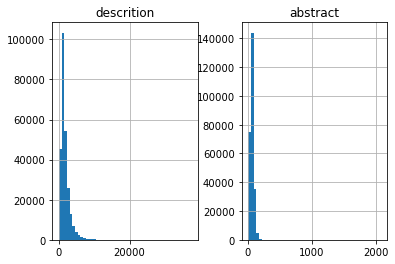

In [29]:

length_df = pd.DataFrame({'descrition': description_word_count, 'abstract': abstract_word_count})
length_df.hist(bins=50)
plt.show()

In [31]:
print(max(description_word_count))
print(max(abstract_word_count))

37456
2074


In [74]:
abstract_count = 0
description_count = 0
count=0
lim_abs =160
lim_des = 9000
file_names = [file for file in os.listdir(os.path.join("data",kind_data,"g")) if ".txt" in file]
for file_name in tqdm(file_names): 

    listJSON = readData(os.path.join("data",kind_data,"g"),file_name)
    for i in range(len(listJSON)) :
        count+=1
        abstract = listJSON[i]['abstract']
        description = listJSON[i]['description']
        
        if(len(abstract.split())<=lim_abs):
            abstract_count += 1
        if(len(description.split())<=lim_des):
            description_count += 1


100%|██████████| 155/155 [00:56<00:00,  2.73it/s]


In [75]:
print(" nombre de description de taille inférieure à ",lim_des , " : ",description_count/count)    
print(" nombre d 'abstract de taille inférieure à ",lim_abs , " : ",abstract_count/count)   
print(count)

 nombre de description de taille inférieure à  9000  :  0.99562438449804
 nombre d 'abstract de taille inférieure à  160  :  0.9963813312221214
258935


In [ ]:

cleaned_text = np.array(cleaned_text)
cleaned_headlines = np.array(cleaned_headlines)

short_text=[]
short_headlines=[]

for i in range(len(cleaned_text)):
    
    if(len(cleaned_headlines[i].split())<=max_headlines_len and len(cleaned_text[i].split())<=max_text_len):
        short_text.append(cleaned_text[i])
        short_headlines.append(cleaned_headlines[i])

        
        


# Tokenization

## Sur Description

In [4]:
kind_data="train"

x_tokenizer = Tokenizer() 
#x_tokenizer.fit_on_texts(_____)

file_names = [file for file in os.listdir(os.path.join("data",kind_data,"g")) if ".txt" in file]
for i in tqdm(range(len(file_names))) : 
    file_name=file_names[i]
    listJSON = readData(os.path.join("data",kind_data,"g"),file_name)

    descriptions = [i['description'] for i in listJSON  ]#listJSON[:]['description']
    x_tokenizer.fit_on_texts(descriptions)

100%|██████████| 155/155 [14:20<00:00,  5.55s/it]


In [5]:
thresh=4
cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in tqdm(x_tokenizer.word_counts.items()):
    tot_cnt=tot_cnt+1
    
    tot_freq=tot_freq+value
    if tot_cnt<10 :
        print(key,value)
    
    
    if(value<thresh):
        
        cnt=cnt+1
        freq=freq+value
    
print("% of rare words in vocabulary:",(cnt/tot_cnt)*100,"%")
print("Total Coverage of rare words:",(freq/tot_freq)*100,"%")

 27%|██▋       | 158561/588085 [00:00<00:00, 777620.22it/s]

referring 367900
fig 5199387
service 309448
technician 13298
visiting 2887
customer 210628
location 405434
provided 808434
input 1283124


100%|██████████| 588085/588085 [00:00<00:00, 702400.92it/s]

% of rare words in vocabulary: 59.7163675319044 %
Total Coverage of rare words: 0.11371321630587963 %


In [6]:
#prepare a LIMITED tokenizer for reviews on training data
tokenizer_description = Tokenizer(num_words=tot_cnt-cnt) 


file_names = [file for file in os.listdir(os.path.join("data",kind_data,"g")) if ".txt" in file]
for i in tqdm(range(len(file_names))) : 
    file_name=file_names[i]
    listJSON = readData(os.path.join("data",kind_data,"g"),file_name)

    descriptions = [i['description'] for i in listJSON  ]
    tokenizer_description.fit_on_texts(descriptions)

100%|██████████| 155/155 [09:13<00:00,  3.57s/it]


## Abstract

In [7]:
x_tokenizer = Tokenizer() 
#x_tokenizer.fit_on_texts(_____)

file_names = [file for file in os.listdir(os.path.join("data",kind_data,"g")) if ".txt" in file]
for i in tqdm(range(len(file_names))) : 
    file_name=file_names[i]
    listJSON = readData(os.path.join("data",kind_data,"g"),file_name)

    abstracts = [i['abstract'] for i in listJSON  ]#listJSON[:]['description']
    x_tokenizer.fit_on_texts(abstracts)

100%|██████████| 155/155 [01:00<00:00,  2.58it/s]


In [8]:
thresh=4
cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in tqdm(x_tokenizer.word_counts.items()):
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    
    if(value<thresh):
        
        cnt=cnt+1
        freq=freq+value
    
print("% of rare words in vocabulary:",(cnt/tot_cnt)*100,"%")
print("Total Coverage of rare words:",(freq/tot_freq)*100,"%")

100%|██████████| 68948/68948 [00:00<00:00, 623812.50it/s]

% of rare words in vocabulary: 47.82009630446134 %
Total Coverage of rare words: 0.2959113934193723 %


In [9]:
#prepare a LIMITED tokenizer for reviews on training label
tokenizer_abstract = Tokenizer(num_words=tot_cnt-cnt) 


file_names = [file for file in os.listdir(os.path.join("data",kind_data,"g")) if ".txt" in file]
for i in tqdm(range(len(file_names))) : 
    file_name=file_names[i]
    listJSON = readData(os.path.join("data",kind_data,"g"),file_name)

    abstracts = [i['abstract'] for i in listJSON  ]
    tokenizer_abstract.fit_on_texts(abstracts)

100%|██████████| 155/155 [00:56<00:00,  2.76it/s]


## Save des token

In [15]:
def create_tokenize_file(path,filename,JSONlist,tokenizer_x,tokenizer_y):
    
    if os.path.exists(path+'new_tok_'+filename+'.txt')==True:
        os.remove(path+'new_tok_'+filename)
        
    descriptions = [i['description'] for i in JSONlist  ]
    x_tr_seq   =  tokenizer_x.texts_to_sequences(descriptions)
    
    
    
    abstracts = [i['abstract'] for i in JSONlist  ]
    y_tr_seq   =  tokenizer_y.texts_to_sequences(abstracts) 
    
    #print(len(x_tr_seq))
    #print(x_tr_seq)
    
    new_f= open(path+'new_tok'+filename,'a')
  
    for i in range(len(JSONlist)) :
        #JSONlist[i]['abstract']=x_tr_seq[i]
        #JSONlist[i]['description']=y_tr_seq[i]
    
        updatedJSON={"publication_number":JSONlist[i]['publication_number'],"abstract":x_tr_seq[i],"description":y_tr_seq[i]}
        new_f.write(json.dumps(updatedJSON))
        
        
    #print("Wrote file "+new_f.name)
    new_f.close()
    
    #f2= open(path+'new_tok'+filename,'r')
    #text = f2.read().replace('}{"publication_number"','}\n{"publication_number"').encode("utf8")
    
    #f2.write(str(text))
    #f2.close()
    
    
    


In [16]:
#### Enregistrement des données tokénisés
os.makedirs("data_token", exist_ok=True)
for kind_data in ["train","val","test"]:
    name_folder0 = "data_token/"+kind_data
    name_folder = "data_token/"+kind_data+"/g"
    os.makedirs(name_folder0, exist_ok=True)
    os.makedirs(name_folder, exist_ok=True)
    
    file_names = [file for file in os.listdir(os.path.join("data",kind_data,"g")) if ".txt" in file]
    for i in tqdm(range(len(file_names))) :
        file_name=file_names[i]
        listJSON = readData(os.path.join("data",kind_data,"g"),file_name) 

        
        
        #Padding ?????????????????????????????????????
        #x_tr    =   pad_sequences(x_tr_seq,  maxlen=max_text_len, padding='post')
        #x_val   =   pad_sequences(x_val_seq, maxlen=max_text_len, padding='post')
    
        #on save ici le fichier à l'adresse
        create_tokenize_file(name_folder+"/",file_name,listJSON,tokenizer_description,tokenizer_abstract)

100%|██████████| 155/155 [00:24<00:00,  6.33it/s]


In [ ]:
##SAVE LES TOKENIZER
##MEME TOKENIZER POUR X ET Y ?????

In [26]:

file_names = [file for file in os.listdir(os.path.join("data","train","g")) if ".txt" in file]
for i in tqdm(range(len(file_names[0]))) : 
    file_name=file_names[i]

    listJSON = readData(os.path.join("data","train","g"),file_name)
    descriptions = [i['description'] for i in listJSON  ]
    abstracts = [i['abstract'] for i in listJSON  ]


x_tr_seq   =  tokenizer_description.texts_to_sequences(descriptions)

print(len(descriptions[0]))
print(len(x_tr_seq[0]))
print(x_tr_seq[0])

print(len(x_tr_seq))
print(len(descriptions))

100%|██████████| 24/24 [00:03<00:00,  6.43it/s]


3867
481
[44, 1160, 40074, 1528, 1821, 7, 867, 303, 1078, 9, 151, 170, 900, 52, 21, 26, 441, 565, 31, 31, 25, 35, 167, 35, 82, 31, 2, 84, 1621, 2361, 3589, 88805, 1887, 1438, 1158, 21, 185, 63696, 2855, 174401, 278, 544, 104, 380, 84, 12517, 1530, 12517, 1530, 167, 6, 35, 82, 121, 380, 84, 170, 900, 170, 900, 2155, 82, 31, 25, 35, 82, 1530, 595, 1096, 5254, 900, 1743, 1814, 28, 1466, 132, 489, 6, 51, 31, 25, 35, 167, 88, 1814, 28, 1466, 132, 2584, 278, 1044, 47, 31, 62, 489, 222, 31, 25, 35, 519, 1044, 278, 25, 900, 519, 136, 278, 17, 808, 1466, 132, 123, 2889, 222, 25, 35, 1466, 132, 583, 104, 278, 1044, 47, 31, 2889, 222, 1031, 867, 1160, 2889, 222, 51, 1466, 132, 25, 35, 293, 121, 28, 1466, 132, 28, 121, 1466, 132, 163, 586, 28, 28, 35, 121, 1466, 132, 1466, 132, 1519, 2889, 222, 4, 2490, 5528, 15210, 847, 1577, 2889, 222, 1189, 222, 2, 762, 1088, 1375, 422, 6094, 222, 7278, 1015, 970, 2, 1541, 147, 4941, 31, 544, 104, 278, 166, 501, 7, 1151, 19970, 508, 3727, 128, 41, 31, 334, 314,

In [ ]:
 for i in range(len(JSONlist)) :
        abstract = JSONlist[i]['abstract']
        description = JSONlist[i]['description']
            
        abstract1 = abstract.lower()
        description1 = description.lower()
            
        abstract2 = re.sub('[^a-zA-Z ]',' ',abstract1)
        description2 = re.sub('[^a-zA-Z ]',' ',description1)
            
        abstract3 = re.sub(r'(?:^| )\w(?:$| )', ' ', abstract2).strip()
        description3 = re.sub(r'(?:^| )\w(?:$| )', ' ', description2).strip()
            
        abstract4 = ' '.join([word for word in abstract3.split() if word not in cachedstopwords])
        description4 = ' '.join([word for word in description3.split() if word not in cachedstopwords])
            
        abstract5=re.sub(' +',' ',abstract4)
        description5=re.sub(' +',' ',description4)
            
        JSONlist[i]['abstract']=abstract5
        JSONlist[i]['description']=description5
        updatedJSON={"publication_number":JSONlist[i]['publication_number'],"abstract":abstract5,"description":description5}
        new_f.write(json.dumps(updatedJSON))
    print("Wrote file "+new_f.name)
    new_f.close()
    return JSONlist

In [48]:


#convert text sequences into integer sequences
x_tr_seq    =   x_tokenizer.texts_to_sequences(x_tr) 
x_val_seq   =   x_tokenizer.texts_to_sequences(x_val)

#padding zero upto maximum length
x_tr    =   pad_sequences(x_tr_seq,  maxlen=max_text_len, padding='post')
x_val   =   pad_sequences(x_val_seq, maxlen=max_text_len, padding='post')

#size of vocabulary ( +1 for padding token)
x_voc   =  x_tokenizer.num_words + 1

print(x_voc)

NameError: name 'x_tr' is not defined